In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Input, Conv2DTranspose, Flatten, Reshape, AvgPool2D, UpSampling2D
from tensorflow.keras.models import Model
import time
import scipy.linalg
from tensorflow.keras.constraints import Constraint
import pickle
import matplotlib.gridspec as gridspec
import time

In [15]:
tf.__version__

'2.1.0'

In [2]:
tf.random.set_seed(1234)
np.random.seed(1234)

In [3]:
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Input data for GANs.
This module provides the input images.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import glob
import math
import os
import random

import numpy as np
import tensorflow as tf

#_DATA_CACHE = None

#DATA_DIR = os.environ['AE_DATA']


class DataSet(object):

    def __init__(self, name, train, test, train_once, height, width, colors,
                 nclass):
        self.name = name
        self.train = train
        self.train_once = train_once
        self.test = test
        self.height = height
        self.width = width
        self.colors = colors
        self.nclass = nclass


def get_dataset(dataset_name, params):
    train, height, width, colors = _DATASETS[dataset_name + '_train'](
        batch_size=params['batch_size'])
    test = _DATASETS[dataset_name + '_test'](batch_size=1)[0]
    train = train.map(lambda v: dict(x=v['x'],
                                     label=tf.one_hot(v['label'],
                                                      _NCLASS[dataset_name])))
    test = test.map(lambda v: dict(x=v['x'],
                                   label=tf.one_hot(v['label'],
                                                    _NCLASS[dataset_name])))
    if dataset_name + '_train_once' in _DATASETS:
        train_once = _DATASETS[dataset_name + '_train_once'](batch_size=1)[0]
        train_once = train_once.map(lambda v: dict(
            x=v['x'], label=tf.one_hot(v['label'], _NCLASS[dataset_name])))
    else:
        train_once = None
    return DataSet(dataset_name, train, test, train_once, height, width,
                   colors, _NCLASS[dataset_name])


def draw_line(angle, height, width, w=2.):
    m = np.zeros((height, width, 1))
    x0 = height*0.5
    y0 = width*0.5
    x1 = x0 + (x0 - 1) * math.cos(-angle)
    y1 = y0 + (y0 - 1) * math.sin(-angle)
    flip = False
    if abs(y0 - y1) < abs(x0 - x1):
        x0, x1, y0, y1 = y0, y1, x0, x1
        flip = True
    if y1 < y0:
        x0, x1, y0, y1 = x1, x0, y1, y0
    x0, x1 = x0 - w / 2, x1 - w / 2
    dx = x1 - x0
    dy = y1 - y0
    ds = dx / dy if dy != 0 else 0
    yi = int(math.ceil(y0)), int(y1)
    points = []
    for y in range(int(y0), int(math.ceil(y1))):
        if y < yi[0]:
            weight = yi[0] - y0
        elif y > yi[1]:
            weight = y1 - yi[1]
        else:
            weight = 1
        xs = x0 + (y - y0 - .5) * ds
        xe = xs + w
        xi = int(math.ceil(xs)), int(xe)
        if xi[0] != xi[1]:
            points.append((y, slice(xi[0], xi[1]), weight))
        if xi[0] != xs:
            points.append((y, int(xs), weight * (xi[0] - xs)))
        if xi[1] != xe:
            points.append((y, xi[1], weight * (xe - xi[1])))
    if flip:
        points = [(x, y, z) for y, x, z in points]
    for y, x, z in points:
        m[y, x] += 2 * z
    m -= 1
    m = m.clip(-1, 1)
    return m


def input_lines(batch_size, size=(32, 32, 1), limit=None):
    h, w, c = size

    def gen():
        count = 0
        while limit is None or count < limit:
            angle = 2 * random.random() * math.pi
            m = draw_line(angle, h, w)
            label = int(10 * angle / (2 * math.pi - 1e-6))
            count += 1
            yield m, label

    ds = tf.data.Dataset.from_generator(gen, (tf.float32, tf.int64),
                                        (size, tuple()))
    ds = ds.map(lambda x, y: dict(x=x, label=y))
    ds = ds.batch(batch_size)
    return ds, size[0], size[1], size[2]


def _parser_all(serialized_example):
    features = tf.parse_single_example(
        serialized_example,
        features={'image': tf.FixedLenFeature([], tf.string),
                  'label': tf.FixedLenFeature([], tf.int64)})
    image = tf.image.decode_image(features['image'])
    image = tf.cast(image, tf.float32) * (2.0 / 255) - 1.0
    label = features['label']
    return image, label


def input_fn_record(record_parse_fn,
                    filenames,
                    batch_size,
                    size=(32, 32, 3),
                    pad=(0, 0),
                    crop=(0, 0),
                    resize=(32, 32),
                    shuffle=1024,
                    repeat=True,
                    random_flip_x=False,
                    random_shift_x=0,
                    random_shift_y=0,
                    limit=None):
    """Creates a Dataset pipeline for tfrecord files.
    Args:
    record_parse_fn: function, used to parse a record entry.
    filenames: list of filenames of the tfrecords.
    batch_size: int, batch size.
    size: tuple (HWC) containing the expected image shape.
    pad: tuple (HW) containing how much to pad y and x axis on each size.
    crop: tuple (HW) containing how much to crop y and x axis.
    resize: tuple (HW) containing the desired image shape.
    shuffle: int, the size of the shuffle buffer.
    repeat: bool, whether the dataset repeats itself.
    random_flip_x: bool, whether to random flip the x-axis.
    random_shift_x: int, amount of random horizontal shift.
    random_shift_y: int, amount of random vertical shift.
    limit: int, the number of samples to drop (<0) or to take (>0)..
    Returns:
    Dataset iterator and 3 ints (height, width, colors).
    """

    def random_shift(v):
        if random_shift_y:
            v = tf.concat([v[-random_shift_y:], v, v[:random_shift_y]], 0)
        if random_shift_x:
            v = tf.concat([v[:, -random_shift_x:], v, v[:, :random_shift_x]],
                          1)
        return tf.random_crop(v, [resize[0], resize[1], size[2]])

    filenames = sum([glob.glob(x) for x in filenames], [])
    if not filenames:
        raise ValueError('Empty dataset, did you mount gcsfuse bucket?')
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(record_parse_fn, max(4, batch_size // 4))
    if limit is not None:
        if limit > 0:
            dataset = dataset.take(limit)
        elif limit < 0:
            dataset = dataset.skip(-limit)
    if repeat:
        dataset = dataset.repeat()
    delta = [0, 0]
    if sum(crop):
        dataset = dataset.map(
            lambda x, y: (x[crop[0]:-crop[0], crop[1]:-crop[1]], y))
        delta[0] -= 2 * crop[0]
        delta[1] -= 2 * crop[1]
    if sum(pad):
        padding = [[pad[0]] * 2, [pad[1]] * 2, [0] * 2]
        dataset = dataset.map(
            lambda x, y: (tf.pad(x, padding, constant_values=-1.), y))
        delta[0] += 2 * crop[0]
        delta[1] += 2 * crop[1]
    if resize[0] - delta[0] != size[0] or resize[1] - delta[1] != size[1]:
        dataset = dataset.map(
            lambda x, y: (tf.image.resize_bicubic([x], list(resize))[0], y), 4)
    if shuffle:
        dataset = dataset.shuffle(shuffle)
    if random_flip_x:
        dataset = dataset.map(
            lambda x, y: (tf.image.random_flip_left_right(x), y), 4)
    if random_shift_x or random_shift_y:
        dataset = dataset.map(lambda x, y: (random_shift(x), y), 4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(
        lambda x, y: dict(
            x=tf.reshape(x, [batch_size] + list(resize) + list(size[-1:])),
            label=y))
    dataset = dataset.prefetch(4)  # Prefetch a few batches.
    return dataset, resize[0] or size[0], resize[1] or size[1], size[2]


_NCLASS = {
    'celeba32': 1,
    'cifar10': 10,
    'lines32': 10,
    'mnist32': 10,
    'svhn32': 10,
}

_DATASETS = {
    'lines32_train': functools.partial(input_lines, size=(32, 32, 1)),
    'lines32_test': functools.partial(input_lines, limit=5000,
                                         size=(32, 32, 1)),
}

In [4]:
dataset = get_dataset('lines32',dict(batch_size = 64))
x_train = dataset.train
x_test = dataset.test

In [4]:
for (x,im),l in dataset.train:
    vae.transform(x)

ValueError: not enough values to unpack (expected 2, got 1)

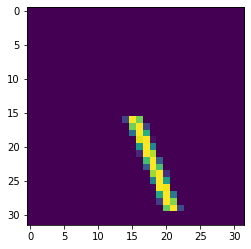

In [5]:
plt.imshow(next(iter(dataset.train))['x'][0].numpy().reshape((32,32)))

In [1]:
next(iter(dataset.train))['x'][0].numpy()

NameError: name 'dataset' is not defined

In [6]:
class Encoder_block(tf.keras.layers.Layer):
    def __init__(self,filters):
        super(Encoder_block,self).__init__()
        self.filters = filters
        self.act = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.conv_1 = Conv2D(filters = self.filters, kernel_size=3, strides = (1,1),padding = 'same')
        self.conv_2 = Conv2D(filters = 2*self.filters, kernel_size=3, strides = (1,1),padding = 'same')
        self.pool = AvgPool2D(pool_size=(2,2), padding='same')
    
    def call(self, input_x, training=False):
        x = self.conv_1(input_x)
        x = self.act(x)
        x = self.conv_2(x)
        x = self.act(x)
        x_out = self.pool(x)
        return x_out
    
    def get_config(self):
      config = super().get_config().copy()

      config.update({'filters': self.filters,
                     'act': self.act,
                     'conv_1': self.conv_1,
                     'conv_2': self.conv_2,
                     'pool': self.pool})
      return config

class Decoder_block(tf.keras.layers.Layer):
    def __init__(self,filters):
        super(Decoder_block,self).__init__()
        self.filters = filters
        self.act = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.conv_1 = Conv2D(filters = self.filters, kernel_size=3, strides = (1,1),padding = 'same')
        self.conv_2 = Conv2D(filters = int(self.filters/2), kernel_size=3, strides = (1,1),padding = 'same')
        self.up = UpSampling2D(size=(2, 2), interpolation="nearest")
    
    def call(self, input_x, training=False):
        x = self.conv_1(input_x)
        x = self.act(x)
        x = self.conv_2(x)
        x = self.act(x)
        x_out = self.up(x)
        return x_out
      
    def get_config(self):
      config = super().get_config().copy()

      config.update({'filters': self.filters,
                     'act': self.act,
                     'conv_1': self.conv_1,
                     'conv_2': self.conv_2,
                     'up': self.up})
      return config

In [7]:
class VAE(tf.keras.Model):
    
    def reparameterize(mean,log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps*tf.exp(log_var * 0.5) + mean
    
    @tf.function
    def calc_loss(self,x):
        mean, logvar = self.transform(x)
        z = VAE.reparameterize(mean,logvar)
        x_rec = self.generate(z)
        x_01 = 0.5*(x+1)
        rec_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits = x_rec, labels = x_01), axis=[1,2,3])
        #rec_loss = tf.reduce_sum(tf.square(x_rec-x), axis=[1,2,3])
        kl_loss = 0.5*tf.reduce_sum(tf.square(mean) + tf.exp(logvar) - logvar -1,axis = 1)
        return tf.reduce_mean(rec_loss + self.beta*kl_loss)
    
    @tf.function
    def apply_gradient(self,x):
        with tf.GradientTape() as tape:
            loss = self.calc_loss(x)
        grad = tape.gradient(loss,self.trainable_variables)
        self.optimizer.apply_gradients(zip(grad,self.trainable_variables))
        
        
        
    def __init__(self,latent_dim= 2, beta = 1, batch_size = 32, n_e=4,n_d=4, w = 2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = 1
        self.batch_size = 32
        self.image_size = (32,32,1)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.n_d = n_d
        self.n_e = n_e
        self.w = w
        self.standard = 33
        
        self.e_block1 = Encoder_block(1)
        self.e_block2 = Encoder_block(2)
        self.e_block3 = Encoder_block(4)
        self.e_block4 = Encoder_block(8)
        
        self.d_block1 = Decoder_block(16)
        self.d_block2 = Decoder_block(8)
        self.d_block3 = Decoder_block(4)
        self.d_block4 = Decoder_block(2)
        
        self.encoder = self.create_encoder3()
        self.decoder = self.create_decoder3()
       
    
    
    def create_encoder_dense(self):
        inp_d = Input(shape=self.image_size)
        fl = Flatten()(inp_d)
        
        for i in range(self.n_e):
            if(i==0):
                x =  Dense(self.standard*self.w,activation='relu')(fl)
            else:
                x =  Dense(self.standard*self.w,activation='relu')(x)
        mean_out = Dense(self.latent_dim)(x)
        log_var_out = Dense(self.latent_dim)(x)
        
        enc_model = Model(inp_d, [mean_out,log_var_out])
        return enc_model
        
    def create_decoder_dense(self):
        inp_d = Input(shape=(self.latent_dim,))
        for i in range(self.n_d):
            if(i==0): 
                x = Dense(self.standard*self.w, activation='relu')(inp_d)
            else: 
                x = Dense(self.standard*self.w, activation='relu')(x)

        den_4 = Dense(self.image_size[0]*self.image_size[1])(x)
        image_out = Reshape(target_shape=self.image_size)(den_4)
        dec_model = Model(inp_d, image_out)
        return dec_model

    
    def create_encoder_CNN_pool(self):
        inp = Input(shape=self.image_size)
        conv_1 = Conv2D(filters = 32, kernel_size=3, strides = (1,1),padding = 'same', activation='relu')(inp)
        conv_2 = Conv2D(filters = 64, kernel_size=3, strides = (1,1),padding = 'same', activation='relu')(conv_1)
        mp1 = MaxPool2D(pool_size=(2,2), padding='valid')(conv_2)
        conv_3 = Conv2D(filters = 64, kernel_size=3, strides = (1,1),padding = 'same', activation='relu')(mp1)
        conv_4 = Conv2D(filters = 64, kernel_size=3, strides = (1,1),padding = 'same', activation='relu')(conv_3)
        mp2 = MaxPool2D(pool_size=(2,2), padding='valid')(conv_4)
        fl = Flatten()(mp2)
        mean_out = Dense(self.latent_dim)(fl)
        log_var_out = Dense(self.latent_dim)(fl)
        
        enc_model = Model(inp, [mean_out,log_var_out])
        return enc_model
        
    def create_decoder_CNN_pool(self):
        inp_c = Input(shape=(self.latent_dim,))
        den = Dense(units=8*8*32, activation='relu')(inp_c)
        rs = Reshape(target_shape=(8,8,32))(den)
        convt_1 = Conv2DTranspose(filters = 32, kernel_size=3, strides = (2,2), padding = 'same', activation='relu')(rs)
        convt_2 = Conv2DTranspose(filters = 64, kernel_size=3, strides = (1,1), padding = 'same', activation='relu')(convt_1)
        convt_3 = Conv2DTranspose(filters = 64, kernel_size=3, strides = (2,2),padding = 'same', activation='relu')(convt_2)
        convt_4 = Conv2DTranspose(filters = 64, kernel_size=3, strides = (1,1),padding = 'same', activation='relu')(convt_3)
        image_out = Conv2DTranspose(filters=1,kernel_size=3,strides=(1,1),padding = 'same')(convt_4)
        dec_model = Model(inp_c, image_out)
        return dec_model
    
    def create_encoder3(self):
        inp = Input(shape=self.image_size)
        x = self.e_block1(inp)
        x = self.e_block2(x)
        x = self.e_block3(x)
        x = self.e_block4(x)
        x = Conv2D(filters = 16, kernel_size=3, strides = (1,1),padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = 16, kernel_size=3, strides = (1,1),padding = 'same')(x)
        fl = Flatten()(x)
        mean_out = Dense(self.latent_dim)(fl)
        log_var_out = Dense(self.latent_dim)(fl)
        
        enc_model = Model(inp, [mean_out,log_var_out])
        return enc_model
        
    def create_decoder3(self):
        inp_c = Input(shape=(self.latent_dim,))
        rs = Reshape(target_shape=(2,2,16))(inp_c)
        x = self.d_block1(rs)
        x = self.d_block2(x)
        x = self.d_block3(x)
        x = self.d_block4(x)
        x = Conv2D(filters = 1, kernel_size=3, strides = (1,1),padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        image_out = Conv2D(filters = 1, kernel_size=3, strides = (1,1),padding = 'same')(x)
        
        
        dec_model = Model(inp_c, image_out)
        return dec_model
    
    def generate(self,z,training = True):
        x = self.decoder(z)
        if not training:
          x = tf.nn.sigmoid(x)
          x = 2.0*x-1
        return x
    
    def transform(self,images):
        return self.encoder(images)
    
    def sample_image(self,n):
        z_sample = tf.random.normal(shape=(n,self.latent_dim))
        return self.generate(z_sample,training = False)
    
    def train(self,epochs,x_dataset,x_test):
        
        for ep in range(1,epochs+1):
            for i in range(100):
                x_batch = next(iter(x_dataset))
                self.apply_gradient(x_batch['x'])
            loss = tf.keras.metrics.Mean()
            for i in range(10):
                test_x = next(iter(x_test))
                loss(self.calc_loss(test_x['x']))
            elbo = -loss.result()
            print('Epoch: {}, Test set ELBO: {}, '.format(ep,elbo))
        return elbo
                
    def kl_loss(self,x):
        mean, logvar = self.transform(x)
        z = VAE.reparameterize(mean,logvar)
        x_rec = self.generate(z)
        
        rec_loss = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits = x_rec, labels = x), axis=[1,2,3])
        kl_loss = -0.5*tf.reduce_sum(tf.square(mean) + tf.exp(logvar) - logvar -1,axis = 1)
        return kl_loss, mean, logvar
    
    def save_model(self,name):
        string_enc = name + '_{}d_encoder.h5'.format(self.latent_dim)
        string_dec = name + '_{}d_decoder.h5'.format(self.latent_dim)
        self.encoder.save(string_enc)
        self.decoder.save(string_dec)
    
    def load_model(self,name_enc,name_dec):
        self.encoder = tf.keras.models.load_model(name_enc)
        self.decoder = tf.keras.models.load_model(name_dec)



                

In [8]:
vae = VAE(latent_dim = 64)
#vae.load_model('gp_2000_8d_encoder.h5','gp_2000_8d_decoder.h5')

In [9]:
vae.encoder = tf.keras.models.load_model('fc64_enc')
vae.decoder = tf.keras.models.load_model('fc64_dec')

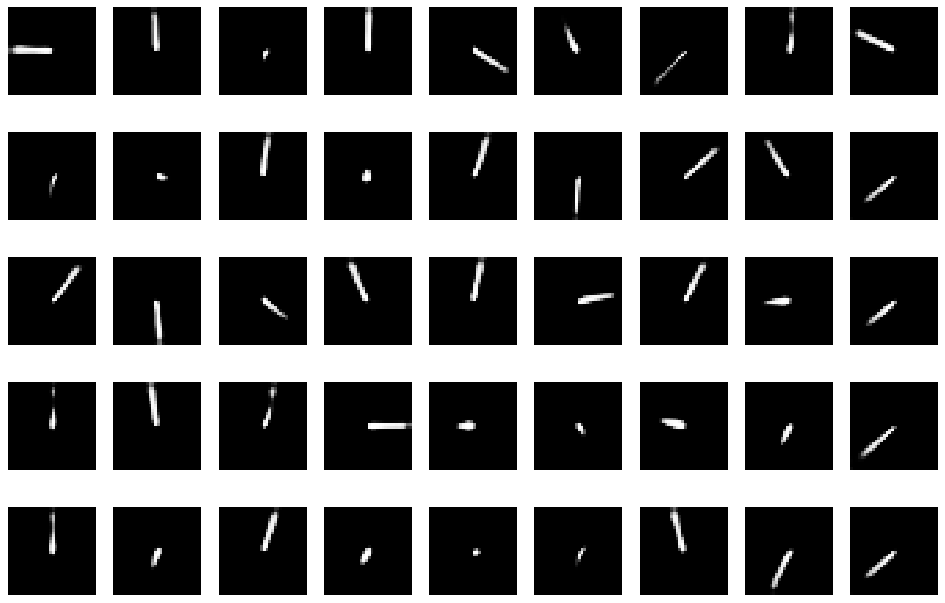

In [10]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(5):
    for j in range(9):
        plt.subplot(5,9,j+9*i+1)
        im = vae.sample_image(1).numpy().reshape((32,32))
        #im[im<0] = -1
        #im[im>0] = 1
        plt.imshow(im,cmap = 'gray')
        plt.axis('off')

In [106]:
tf.exp(vae.encoder(next(iter(x_test))['x'])[1])

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[9.9291873e-01, 3.7497960e-03, 9.8426652e-01, 9.5706540e-01,
        1.0027715e+00, 1.4175124e-04, 9.9381262e-01, 9.7223371e-01]],
      dtype=float32)>

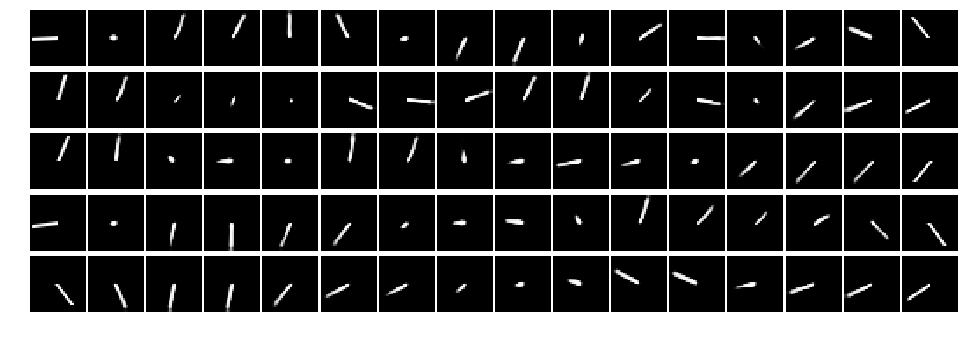

In [17]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
sq_sq = 0.01
d = 64
for j in range(5):
    x_0 = next(iter(x_test))['x'].numpy()
    x_1 = next(iter(x_test))['x'].numpy()
    z_0 = vae.transform(x_0)[0].numpy()
    z_1 = vae.transform(x_1)[0].numpy()
    z_li = np.concatenate((z_0,z_1))
    t_li = np.array([[0,1]]).T
    for i in range(14):
        t = np.array([[(i+1)/15.]])
        m = np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),z_li)
        SIGMA = k(t,t) - np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),k(t_li,t))
        z = np.random.multivariate_normal(m.reshape(d),SIGMA*np.eye(d)).reshape((1,d))
        t_li = np.concatenate((t_li,t))
        z_li = np.concatenate((z_li,z))
    x_li = vae.generate(z_li,training=False)
    plt.subplot(5,16,1+j*16)
    plt.imshow(x_0.reshape((32,32)),cmap = 'gray')
    plt.axis('off')
    for i in range(2,16):
        plt.subplot(5,16,i+j*16)
        plt.imshow(x_li[i].numpy().reshape((32,32)),cmap = 'gray')
        plt.axis('off')
    plt.subplot(5,16,16+j*16)
    plt.imshow(x_1.reshape((32,32)),cmap = 'gray')
    plt.axis('off')

In [218]:
t = np.array([[0.96]])
np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li))),k(t_li,t))

array([[0.63570342]])

In [232]:
m = np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li))),z_li)
SIGMA = k(t,t) - np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li))),k(t_li,t))

In [233]:
SIGMA

array([[6.14605866]])

In [16]:
def k(x,x_p):
    l = 0.01
    return np.exp(-1/(2*l)*(-2*np.dot(x,x_p.T) + np.square(x) + np.square(x_p).T))

In [101]:
np.concatenate((z_0,z_1)).shape

(2, 64)

In [91]:
x = np.array([[0,1]]).T
x_p = np.array([[1/15.]]).T
k(x_p,x)
np.matmul(k(x_p,x),np.linalg.inv(k(x,x)))
y = np.zeros((2,64))
y[0] = z_0
y[1] = z_1
m = np.matmul(np.matmul(k(x_p,x),np.linalg.inv(k(x,x))),y)
SIGMA = k(x_p,x_p) - np.matmul(np.matmul(k(x_p,x),np.linalg.inv(k(x,x))),k(x,x_p))


In [97]:
z = np.random.multivariate_normal(m.reshape(64),SIGMA*np.eye(64))

In [102]:
z.shape

(64,)

In [ ]:


m = np.matmul(np.matmul(k(x_p,x),np.linalg.inv(k(x,x)+ sigma_sq*np.eye(nr_x))),y)


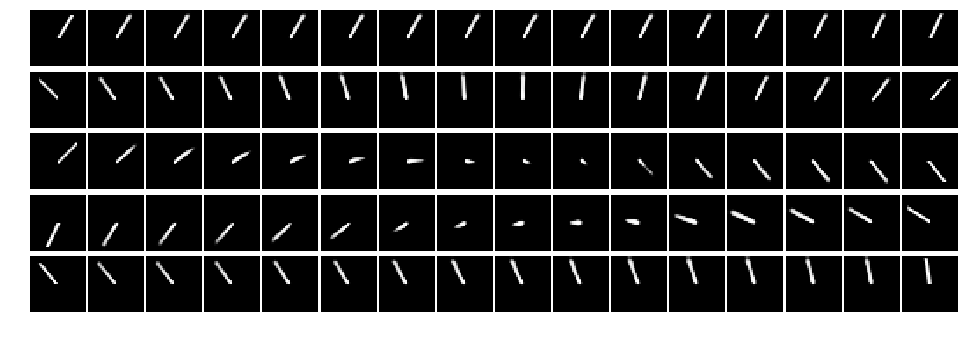

In [55]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
d = 64
for j in range(5):
    x_0 = next(iter(x_test))['x'].numpy()
    x_1 = next(iter(x_test))['x'].numpy()
    z_0 = vae.transform(x_0)[0].numpy()
    z_1 = vae.transform(x_1)[0].numpy()
    z_li = np.zeros((14,d))
    for i in range(14):
        z_li[i] = z_0 + (i+1)/15.*(z_1-z_0)
    x_li = vae.generate(z_li, training= False)
    plt.subplot(5,16,1+j*16)
    plt.imshow(x_0.reshape((32,32)),cmap = 'gray')
    plt.axis('off')
    for i in range(14):
        plt.subplot(5,16,i+2+j*16)
        plt.imshow(x_li[i].numpy().reshape((32,32)),cmap = 'gray')
        plt.axis('off')
    plt.subplot(5,16,16+j*16)
    plt.imshow(x_1.reshape((32,32)),cmap = 'gray')
    plt.axis('off')

In [11]:
def get_mu_sigma(n, vae,x_test):
    mu_list = np.zeros((n,vae.latent_dim))
    log_sigma_list = np.zeros((n,vae.latent_dim))
    for i in range(n):
        z_emp = vae.transform(next(iter(dataset.test))['x'])
        mu_list[i] = z_emp[0].numpy()
        log_sigma_list[i] = z_emp[1].numpy()
    return (mu_list, log_sigma_list)

def draw_lz(batch_size,mu,sigma,d):
    lis = np.zeros((batch_size,d))
    for i in range(batch_size):
        n = len(mu)
        ind = np.random.choice(n)
        z = np.random.normal(loc=mu[ind], scale= np.exp(1/2*sigma[ind]))
        lis[i,:] = z
    return lis

def loss_f(y,x):
    return tf.math.reduce_mean(tf.math.multiply(y,x))
    
def get_test_function(latent_dim,c, sigmoid = True):
    inp_layer = Input(shape=(latent_dim,))
    lay_1 = Dense(200, activation = 'tanh', kernel_constraint=Between(-c,c),bias_constraint=Between(-c,c))(inp_layer)
    lay_2 = Dense(100, activation = 'relu', kernel_constraint=Between(-c,c),bias_constraint=Between(-c,c))(lay_1)
    lay_2 = Dense(20, activation = 'relu', kernel_constraint=Between(-c,c),bias_constraint=Between(-c,c))(lay_1)
    if sigmoid:
        out = Dense(1,activation='sigmoid',kernel_constraint=Between(-c,c),bias_constraint=Between(-c,c))(lay_2)
    else:
        out = Dense(1,kernel_constraint=Between(-c,c),bias_constraint=Between(-c,c))(lay_2)
    test_function = Model(inp_layer, out)
    test_function.compile(optimizer='adam', loss=loss_f)
    return test_function

def get_test_function2(latent_dim,c, sigmoid = True):
    inp_layer = Input(shape=(latent_dim,))
    lay_1 = Dense(200, activation = 'tanh')(inp_layer)
    lay_2 = Dense(100, activation = 'relu')(lay_1)
    lay_2 = Dense(20, activation = 'relu')(lay_1)
    if sigmoid:
        out = Dense(1,activation='sigmoid')(lay_2)
    else:
        out = Dense(1)(lay_2)
    test_function = Model(inp_layer, out)
    test_function.compile(optimizer='adam', loss=loss_f)
    return test_function

class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):        
        return tf.keras.backend.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

def train(epoch, batch_size, latent_dim,mu_list, log_sigma_list, test_function):
    y_list = np.zeros((2*batch_size,))
    start = time.time()
    for i in range(1,epoch+1):
        
        lz_sample = draw_lz(batch_size,mu_list,log_sigma_list,latent_dim).reshape(batch_size,latent_dim)
        y_list[0:batch_size] = -np.ones((batch_size,))
        z_sample = np.random.normal(size = (batch_size,latent_dim))
        y_list[batch_size:] = np.ones((batch_size,))
        l3 = test_function.train_on_batch(x = np.concatenate((lz_sample,z_sample)), y = y_list)
        if (i%1000 == 0):
            print("epoch: {}, loss: {}, time: {:.0f}".format(i,-l3, time.time()-start))
            start = time.time()

In [12]:
start = time.time()
mu_list, log_var = get_mu_sigma(10000,vae,x_test)
print(time.time()-start)

196.1735384464264


In [13]:
test_function = get_test_function2(64,1,True)
train(epoch = 10000, batch_size=2000, latent_dim=64, mu_list = mu_list, log_sigma_list = log_var, test_function = test_function)

epoch: 1000, loss: 0.2884472608566284, time: 96
epoch: 2000, loss: 0.2983167767524719, time: 96
epoch: 3000, loss: 0.30578917264938354, time: 96
epoch: 4000, loss: 0.316588819026947, time: 96
epoch: 5000, loss: 0.3119144141674042, time: 96
epoch: 6000, loss: 0.3189432919025421, time: 95
epoch: 7000, loss: 0.3173058331012726, time: 96
epoch: 8000, loss: 0.32259342074394226, time: 95
epoch: 9000, loss: 0.31546550989151, time: 95
epoch: 10000, loss: 0.32915106415748596, time: 95


In [63]:
z_r = np.random.normal(0,1,size = (1,8))
a = test_function(z_r).numpy()

In [15]:
def sample_f(vae,f,a,b):
    n = 0
    while True:
        n +=1
        z = np.random.normal(0,1,size=(1,64))
        alpha = f(z).numpy()[0][0]
        if alpha<b and alpha>a:
            return vae.generate(z, training =False).numpy()

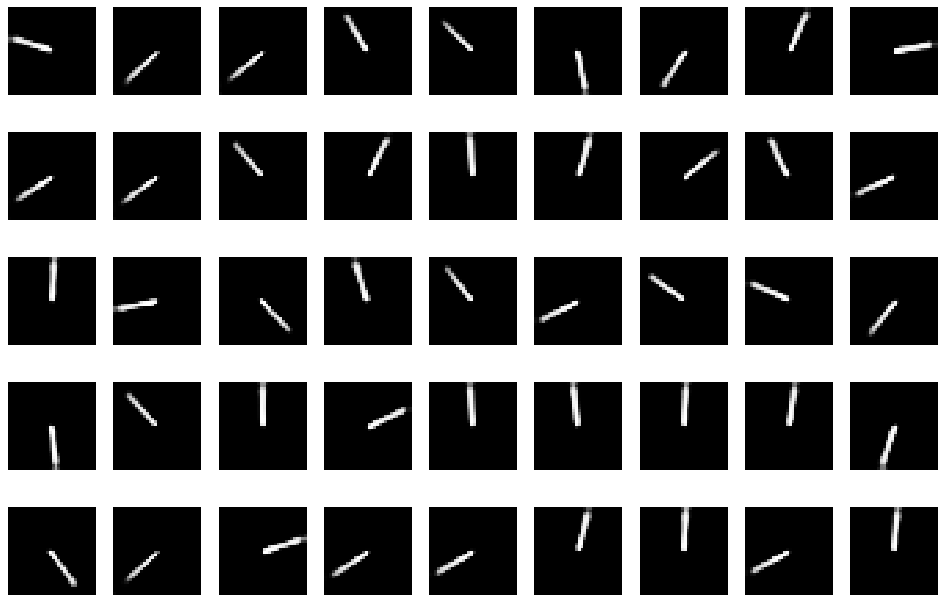

In [16]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(5):
    for j in range(9):
        plt.subplot(5,9,j+9*i+1)
        x = sample_f(vae,test_function,0.9,1)
        plt.imshow(x.reshape((32,32)),cmap = 'gray')
        plt.axis('off')

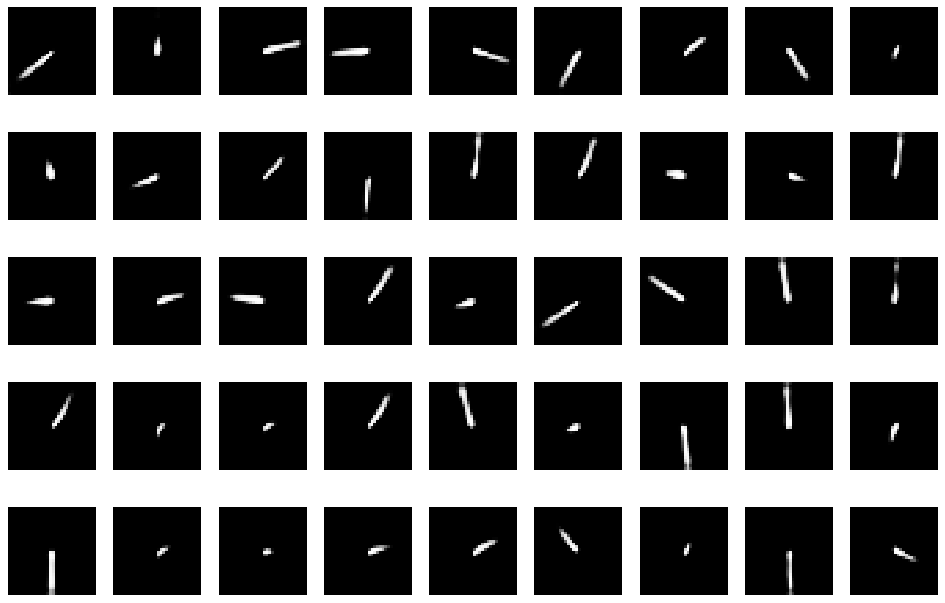

In [17]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(5):
    for j in range(9):
        plt.subplot(5,9,j+9*i+1)
        x = sample_f(vae,test_function,0,0.1)
        plt.imshow(x.reshape((32,32)),cmap = 'gray')
        plt.axis('off')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13


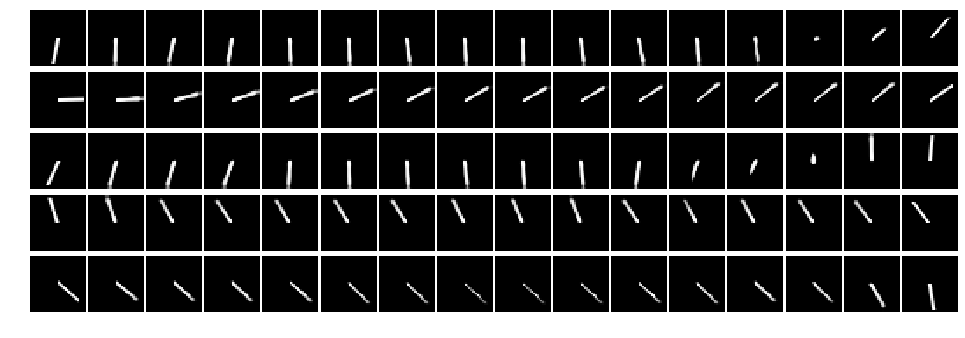

In [45]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
sq_sq = 0.01
p = 5
q = 16
for j in range(p):
    x_0 = next(iter(x_test))['x'].numpy()
    x_1 = next(iter(x_test))['x'].numpy()
    z_0 = vae.transform(x_0)[0].numpy()
    z_1 = vae.transform(x_1)[0].numpy()
    z_li = np.concatenate((z_0,z_1))
    t_li = np.array([[0,1]]).T
    for i in range(q-2):
        print(i)
        t = np.array([[(i+1.)/(q-1)]])
        m = np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),z_li)
        SIGMA = k(t,t) - np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),k(t_li,t))
        while True:
            z = np.random.multivariate_normal(m.reshape(64),SIGMA*np.eye(64)).reshape((1,64))
            alpha = test_function(z).numpy()[0][0]
            u = np.random.rand()
            if u<alpha+1e-4:
                break
        t_li = np.concatenate((t_li,t))
        z_li = np.concatenate((z_li,z))
    x_li = vae.generate(z_li, training = False)
    plt.subplot(p,q,1+j*q)
    plt.imshow(x_0.reshape((32,32)),cmap = 'gray')
    plt.axis('off')
    for i in range(2,q):
        plt.subplot(p,q,i+j*q)
        plt.imshow(x_li[i].numpy().reshape((32,32)),cmap = 'gray')
        plt.axis('off')
    plt.subplot(p,q,q+j*q)
    plt.imshow(x_1.reshape((32,32)),cmap = 'gray')
    plt.axis('off')

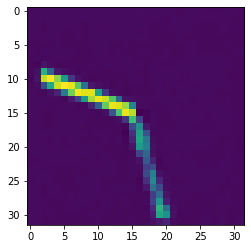

In [108]:
plt.imshow(vae.generate(z_li[16:17]).numpy().reshape((32,32)))

In [114]:
z_li[26]

array([-0.60236456,  0.10545253,  0.12915167, -0.16452934,  1.38191232,
       -0.89326193,  0.26775263, -0.43868405])

(-0.5, 31.5, 31.5, -0.5)

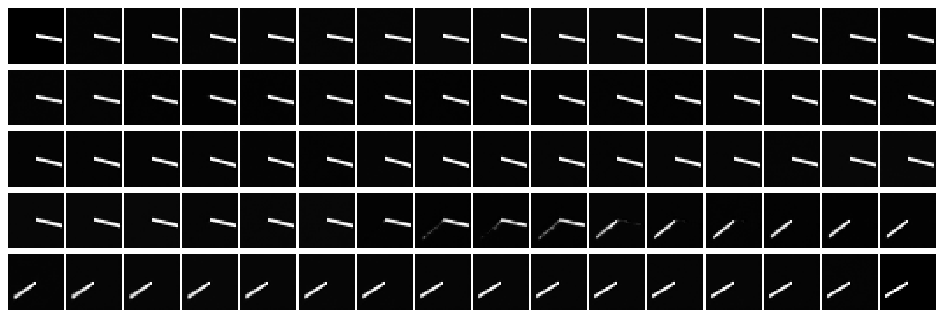

In [138]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
sq_sq = 0.01
p = 80
x_0 = next(iter(dataset.test))['x'].numpy()
x_1 = next(iter(dataset.test))['x'].numpy()
z_0 = vae.transform(x_0)[0].numpy()
z_1 = vae.transform(x_1)[0].numpy()
z_li = np.concatenate((z_0,z_1))
t_li = np.array([[0,1]]).T
for i in range(80-2):
    t = np.array([[(i+1.)/(p-1)]])
    m = np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),z_li)
    SIGMA = k(t,t) - np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),k(t_li,t))
    while True:
        z = np.random.multivariate_normal(m.reshape(8),SIGMA*np.eye(8)).reshape((1,8))
        alpha = test_function(z).numpy()[0][0]
        u = np.random.rand()
        if u<alpha+1e-4:
            break
    t_li = np.concatenate((t_li,t))
    z_li = np.concatenate((z_li,z))
x_li = vae.generate(z_li)
plt.subplot(5,16,1)
plt.imshow(x_0.reshape((32,32)),cmap = 'gray')
plt.axis('off')
for i in range(2,p):
    plt.subplot(5,16,i)
    plt.imshow(x_li[i].numpy().reshape((32,32)),cmap = 'gray')
    plt.axis('off')
plt.subplot(5,16,p)
plt.imshow(x_1.reshape((32,32)),cmap = 'gray')
plt.axis('off')

In [133]:
z_li[1]

array([-3.86624187e-01, -1.72867533e-03,  1.78188169e+00, -5.41982651e-01,
        2.63243675e-01,  6.56726003e-01, -3.31037492e-02,  1.28469920e+00])

In [136]:
t_li

array([[0.        ],
       [1.        ],
       [0.06666667],
       [0.13333333],
       [0.2       ],
       [0.26666667],
       [0.33333333],
       [0.4       ],
       [0.46666667],
       [0.53333333],
       [0.6       ],
       [0.66666667],
       [0.73333333],
       [0.8       ],
       [0.86666667],
       [0.93333333],
       [1.        ],
       [1.06666667],
       [1.13333333],
       [1.2       ],
       [1.26666667],
       [1.33333333],
       [1.4       ],
       [1.46666667],
       [1.53333333],
       [1.6       ],
       [1.66666667],
       [1.73333333],
       [1.8       ],
       [1.86666667],
       [1.93333333],
       [2.        ],
       [2.06666667],
       [2.13333333],
       [2.2       ],
       [2.26666667],
       [2.33333333],
       [2.4       ],
       [2.46666667],
       [2.53333333],
       [2.6       ],
       [2.66666667],
       [2.73333333],
       [2.8       ],
       [2.86666667],
       [2.93333333],
       [3.        ],
       [3.066

In [32]:
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Evaluation functions.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#from lib import data
import numpy as np
import scipy.spatial


def closest_line(query_lines, metric='cosine'):
    """Compute the distance to, and parameters for, the closest line to each
    line in query_lines.
    Args:
        - query_lines: Array of lines to compute closest matches for, shape
            (n_lines, width, height, 1)
        - metric: String to pass to scipy.spatial.distance.cdist to choose
            which distance metric to use
    Returns:
        - min_dist, starts, ends: Arrays of shape (n_lines,) denoting the
            distance to the nearest ``true'' line and the start and end points.
    """
    h, w = query_lines.shape[1:-1]
    # Construct 10000 lines with these dimensions
    angles = np.linspace(0, 2*np.pi - 2*np.pi/10000, 10000)
    all_lines = np.array(
        [(draw_line(angle, h, w)) for angle in angles])
    # Produce vectorized versions of both for use with scipy.spatial
    flat_query = query_lines.reshape(query_lines.shape[0], -1)
    flat_all = all_lines.reshape(all_lines.shape[0], -1)
    # Compute pairwise distance matrix of query lines with all valid lines
    distances = scipy.spatial.distance.cdist(flat_query, flat_all, metric)
    min_dist_idx = np.argmin(distances, axis=-1)
    min_dist = distances[np.arange(distances.shape[0]), min_dist_idx]
    angles = np.array([angles[n] for n in min_dist_idx])
    return min_dist, angles


def smoothness_score(angles):
    """Computes the smoothness score of a line interpolation according to the
    angles of each line.
    Args:
        - angles: Array of shape (n_interpolations, n_lines_per_interpolation)
            giving the angle of each line in each interpolation.
    Returns:
        - smoothness_scores: Array of shape (n_interpolations,) giving the
            average smoothness score for all of the provided interpolations.
    """
    angles = np.atleast_2d(angles)
    # Remove discontinuities larger than np.pi
    angles = np.unwrap(angles)
    diffs = np.abs(np.diff(angles, axis=-1))
    # Compute the angle difference from the first and last point
    total_diff = np.abs(angles[:, :1] - angles[:, -1:])
    # When total_diff is zero, there's no way to compute this score
    zero_diff = (total_diff < 1e-4).flatten()
    normalized_diffs = diffs/total_diff
    deviation = np.max(normalized_diffs, axis=-1) - 1./(angles.shape[1] - 1)
    # Set score to NaN when we aren't able to compute it
    deviation[zero_diff] = np.nan
    return deviation


def line_eval(interpolated_lines):
    """Given a group of line interpolations, compute mean nearest line distance
    and mean smoothness score for all of the interpolations.
    This version of this metric is meant for vertical lines only.
    Args:
        - interpolated_lines: Collection of line interpolation images, shape
            (n_interpolations, n_lines_per_interpolation, height, width, 1)
    Returns:
        - mean_distance: Average distance to closest ``real'' line.
        - mean_smoothness: Average interpolation smoothness
    """
    original_shape = interpolated_lines.shape
    min_dist, angles = closest_line(
        interpolated_lines.reshape((-1,) + original_shape[2:]))
    mean_distance = np.mean(min_dist)
    smoothness_scores = smoothness_score(
        angles.reshape(original_shape[0], original_shape[1]))
    nan_scores = np.isnan(smoothness_scores)
    # If all scores were NaN, set the mean score to NaN
    if np.all(nan_scores):
        mean_smoothness = np.nan
    # Otherwise only compute mean for non-NaN scores
    else:
        sum_smoothness = np.sum(smoothness_scores[np.logical_not(nan_scores)])
        mean_smoothness = sum_smoothness/float(len(nan_scores))
    return np.float32(mean_distance), np.float32(mean_smoothness)

In [151]:
def get_interpolation_linear(nr_images,x_0,x_1):
    d = 64
    z_0 = vae.transform(x_0)[0].numpy()
    z_1 = vae.transform(x_1)[0].numpy()
    z_li = np.zeros((nr_images-2,d))
    for i in range(0,nr_images-2):
        z_li[i] = z_0 + (i+1.)/(nr_images-1)*(z_1-z_0)
    x_li = vae.generate(z_li,training = False)
    inter_images = np.zeros((nr_images,32,32,1))
    inter_images[0] = x_0
    inter_images[-1] = x_1
    inter_images[1:-1,:,:,:] = x_li
    return inter_images

def get_interpolation_gaussian(nr_images,x_0,x_1):
    d = 64
    z_0 = vae.transform(x_0)[0].numpy()
    z_1 = vae.transform(x_1)[0].numpy()
    z_li = np.concatenate((z_0,z_1))
    t_li = np.array([[0,1]]).T
    sq_sq = 0.001
    for i in range(nr_images-2):
        t = np.array([[(i+1)/(nr_images-1)]])
        m = np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),z_li)
        SIGMA = k(t,t) - np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),k(t_li,t))
        z = np.random.multivariate_normal(m.reshape(d),SIGMA*np.eye(d)).reshape((1,d))
        t_li = np.concatenate((t_li,t))
        z_li = np.concatenate((z_li,z))
    x_li = vae.generate(z_li[2:],training = False)
    inter_images = np.zeros((nr_images,32,32,1))
    inter_images[1:-1,:,:,:] = x_li
    inter_images[0] = x_0
    inter_images[-1] = x_1
    return inter_images

def get_interpolation_f(nr_images,x_0,x_1):
    d = 64
    z_0 = vae.transform(x_0)[0].numpy()
    z_1 = vae.transform(x_1)[0].numpy()
    z_li = np.concatenate((z_0,z_1))
    t_li = np.array([[0,1]]).T
    sq_sq = 0.001
    for i in range(nr_images-2):
        t = np.array([[(i+1)/(nr_images-1)]])
        m = np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),z_li)
        SIGMA = k(t,t) - np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),k(t_li,t))
        while True:
            z = np.random.multivariate_normal(m.reshape(d),SIGMA*np.eye(d)).reshape((1,d))
            alpha = test_function(z).numpy()[0][0]
            u = np.random.rand()
            if u<alpha+1e-2:
                break
        t_li = np.concatenate((t_li,t))
        z_li = np.concatenate((z_li,z))
    x_li = vae.generate(z_li[2:],training = False)
    inter_images = np.zeros((nr_images,32,32,1))
    inter_images[1:-1,:,:,:] = x_li
    inter_images[0] = x_0
    inter_images[-1] = x_1
    return inter_images
def k(x,x_p):
    l = 0.1
    return np.exp(-1/(2*l)*(-2*np.dot(x,x_p.T) + np.square(x) + np.square(x_p).T))

In [152]:
nr_inter = 10
nr_image = 100
interpolated_lines_g = np.zeros((nr_inter,nr_image,32,32,1))
interpolated_lines = np.zeros((nr_inter,nr_image,32,32,1))
interpolated_lines_f = np.zeros((nr_inter,nr_image,32,32,1))
for i in range(nr_inter):
    start = time.time()
    print('--------------------------------------------')

    x_0 = next(iter(x_test))['x'].numpy()
    x_1 = next(iter(x_test))['x'].numpy()
    interpolated_lines_g[i,:,:,:,:] = get_interpolation_gaussian(nr_image,x_0,x_1)
    interpolated_lines[i,:,:,:,:] = get_interpolation_linear(nr_image,x_0,x_1)
    interpolated_lines_f[i,:,:,:,:] = get_interpolation_f(nr_image,x_0,x_1)
    print('image nr: {}\t time: {}'.format(i,time.time()-start))

--------------------------------------------
image nr: 0	 time: 1.3861327171325684
--------------------------------------------
image nr: 1	 time: 9.420424699783325
--------------------------------------------
image nr: 2	 time: 8.630462408065796
--------------------------------------------
image nr: 3	 time: 3.4720449447631836
--------------------------------------------
image nr: 4	 time: 3.8551297187805176
--------------------------------------------
image nr: 5	 time: 9.507342338562012
--------------------------------------------
image nr: 6	 time: 2.5336618423461914
--------------------------------------------
image nr: 7	 time: 0.6167106628417969
--------------------------------------------
image nr: 8	 time: 0.531898021697998
--------------------------------------------
image nr: 9	 time: 3.241946220397949


In [143]:
d = 64
nrimages = 16
z_0 = vae.transform(x_0)[0].numpy()
z_1 = vae.transform(x_1)[0].numpy()
z_li = np.concatenate((z_0,z_1))
t_li = np.array([[0,1]]).T
sq_sq = 0.001
for i in range(nr_images-2):
    t = np.array([[(i+1)/(nr_images-1)]])
    m = np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),z_li)
    SIGMA = k(t,t) - np.matmul(np.matmul(k(t,t_li),np.linalg.inv(k(t_li,t_li)+sq_sq*np.eye(len(t_li)))),k(t_li,t))
    z = np.random.multivariate_normal(m.reshape(d),SIGMA*np.eye(d)).reshape((1,d))
    t_li = np.concatenate((t_li,t))
    z_li = np.concatenate((z_li,z))
x_li = vae.generate(z_li[1:-1],training = False)
inter_images = np.zeros((nr_images,32,32,1))
inter_images[1:-1,:,:,:] = x_li
inter_images[0] = x_0
inter_images[-1] = x_1

In [142]:
t_li

array([[ 0.    ],
       [ 1.    ],
       [-0.9375],
       [-0.875 ],
       [-0.8125],
       [-0.75  ],
       [-0.6875],
       [-0.625 ],
       [-0.5625],
       [-0.5   ],
       [-0.4375],
       [-0.375 ],
       [-0.3125],
       [-0.25  ],
       [-0.1875],
       [-0.125 ]])

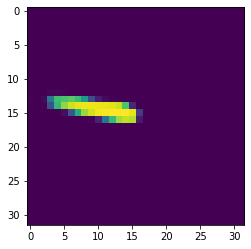

In [144]:
plt.imshow(inter_images[-2].reshape((32,32)))

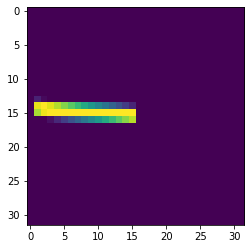

In [145]:
plt.imshow(x_1.reshape((32,32)))

In [52]:
nr_inter = 10
nr_image = 16
interpolated_lines = np.zeros((nr_inter,nr_image,32,32,1))
for i in range(nr_inter):
    interpolated_lines[i,:,:,:,:] = get_interpolation_linear(nr_image)

In [52]:
nr_inter = 10
nr_image = 16
interpolated_lines = np.zeros((nr_inter,nr_image,32,32,1))
for i in range(nr_inter):
    print(i)
    interpolated_lines[i,:,:,:,:] = get_interpolation_f(nr_image)

0


TypeError: get_interpolation_f() missing 2 required positional arguments: 'x_0' and 'x_1'

In [153]:
line_eval(interpolated_lines)

(0.00840717, 0.2731271)

In [154]:
line_eval(interpolated_lines_g)

(0.0071288953, 0.3833834)

In [155]:
line_eval(interpolated_lines_f)

(0.005625081, 0.2213424)

KeyboardInterrupt: 

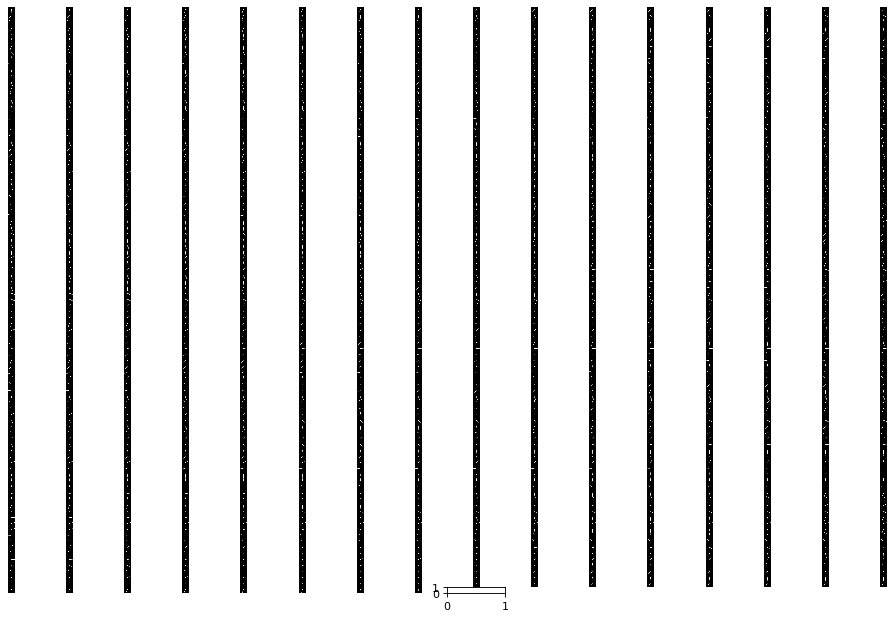

In [75]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
for i in range(nr_inter):
    for j in range(nr_image):
        plt.subplot(nr_inter,nr_image,1+j+nr_image*i)
        plt.imshow(interpolated_lines[i,j].reshape((32,32)),cmap = 'gray')
        plt.axis('off')

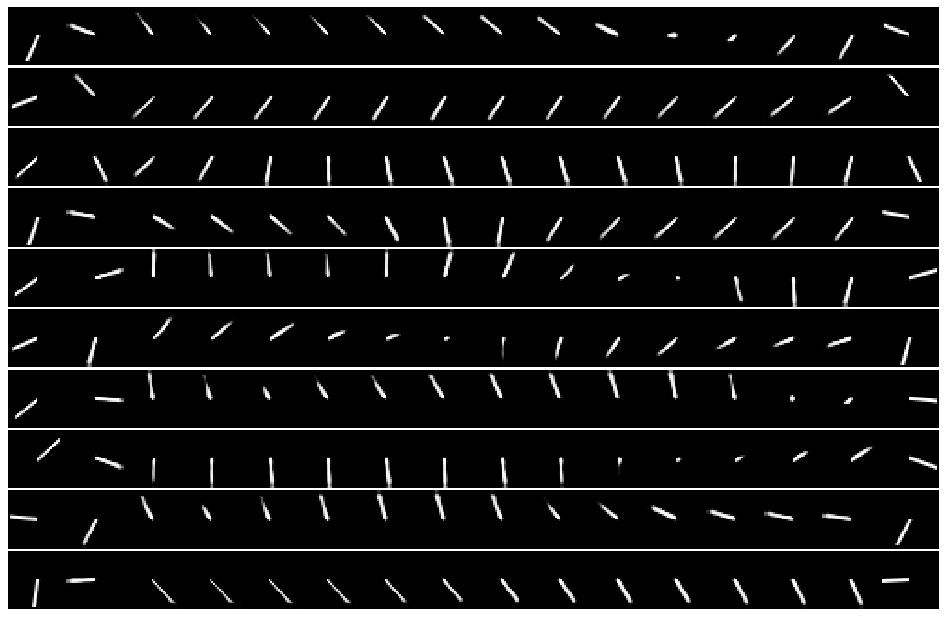

In [59]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
for i in range(nr_inter):
    for j in range(nr_image):
        plt.subplot(nr_inter,nr_image,1+j+nr_image*i)
        plt.imshow(interpolated_lines_g[i,j].reshape((32,32)),cmap = 'gray')
        plt.axis('off')

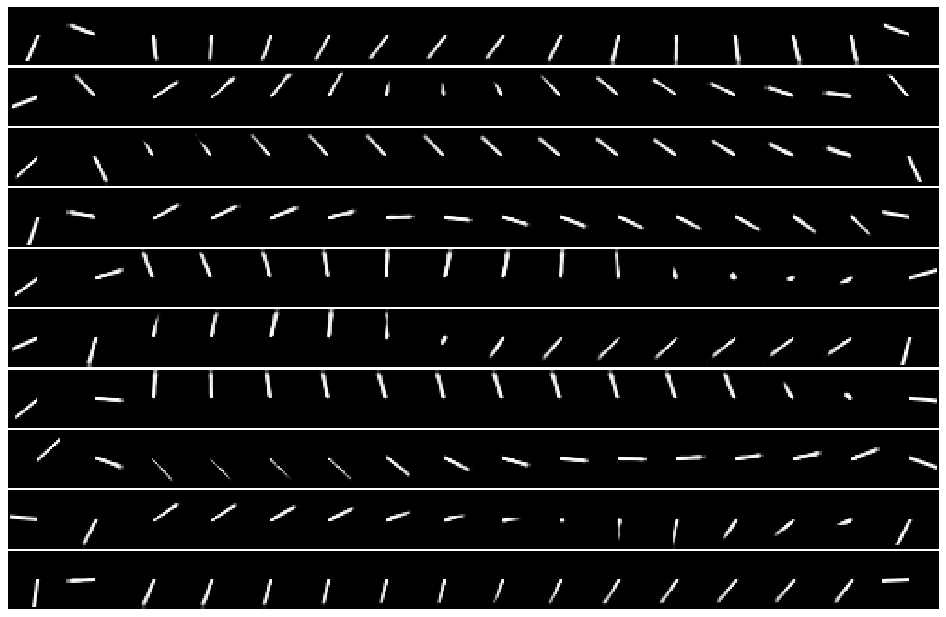

In [60]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
for i in range(nr_inter):
    for j in range(nr_image):
        plt.subplot(nr_inter,nr_image,1+j+nr_image*i)
        plt.imshow(interpolated_lines_f[i,j].reshape((32,32)),cmap = 'gray')
        plt.axis('off')

plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
for i in range(5):
    for j in range(20):
        plt.subplot(5,20,1+20*i+j)
        plt.imshow(interpolated_lines_f[0,j+20*i].reshape((32,32)),cmap = 'gray')
        #plt.xlabel(j+i*j)
        plt.axis('off')

In [82]:
interpolated_lines.shape

(100, 16, 32, 32, 1)

In [46]:
x_0 = next(iter(x_test))['x']
x_1 = next(iter(x_test))['x']
z_0 = vae.transform(x_0)[0].numpy()
z_1 = vae.transform(x_1)[0].numpy()
z_li = np.zeros((nr_image-2,8))
for i in range(0,nr_image-2):
    z_li[i] = z_0 + (i+1.)/(nr_image-1)*(z_1-z_0)
x_li = vae.generate(z_li)
inter_images = np.zeros((nr_image,32,32,1))
inter_images[0] = x_0
inter_images[-1] = x_1
inter_images[1:-1,:,:,:] = x_li

In [49]:
nr_inter = 10
nr_image = 16
interpolated_lines = np.zeros((nr_inter,nr_image,32,32,1))
for i in range(nr_inter):
    interpolated_lines[i,:,:,:,:] = get_interpolation_linear(nr_image)

array([[[[[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         ...,

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]]],


        [[[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan

In [52]:
a = get_interpolation_linear(nr_image)